In [1]:
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import torchinfo
import torchvision.transforms as T

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
import numpy as np

import os
from pathlib import Path
from glob import glob
import json
from tqdm import tqdm

# Ultralytics
import ultralytics

# 디바이스

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# 데이터 전처리

In [3]:
BASE_DIR = Path().resolve()
DATA_DIR = BASE_DIR / 'data' / 'ai03-level1-project'

ANNOTATIONS_DIR = DATA_DIR / 'train_annotations'
TRAIN_IMAGES_DIR = DATA_DIR / 'train_images'
TEST_IMAGES_DIR = DATA_DIR / 'test_images'


print(ANNOTATIONS_DIR)
print(TRAIN_IMAGES_DIR)
print(TEST_IMAGES_DIR)

C:\Users\USER\Desktop\dev\Deep Learning\YOLOv1\data\ai03-level1-project\train_annotations
C:\Users\USER\Desktop\dev\Deep Learning\YOLOv1\data\ai03-level1-project\train_images
C:\Users\USER\Desktop\dev\Deep Learning\YOLOv1\data\ai03-level1-project\test_images


In [4]:
json_paths = glob(os.path.join(ANNOTATIONS_DIR, "**", "*.json"), recursive=True)
train_image_paths = glob(os.path.join(TRAIN_IMAGES_DIR, "**", "*.png"), recursive=True)
test_image_paths = glob(os.path.join(TEST_IMAGES_DIR, "**", "*.png"), recursive=True)

print(json_paths)
print(len(train_image_paths))
print(len(test_image_paths))

['C:\\Users\\USER\\Desktop\\dev\\Deep Learning\\YOLOv1\\data\\ai03-level1-project\\train_annotations\\K-001900-010224-016551-031705_json\\K-001900\\K-001900-010224-016551-031705_0_2_0_2_70_000_200.json', 'C:\\Users\\USER\\Desktop\\dev\\Deep Learning\\YOLOv1\\data\\ai03-level1-project\\train_annotations\\K-001900-010224-016551-031705_json\\K-001900\\K-001900-010224-016551-031705_0_2_0_2_75_000_200.json', 'C:\\Users\\USER\\Desktop\\dev\\Deep Learning\\YOLOv1\\data\\ai03-level1-project\\train_annotations\\K-001900-010224-016551-031705_json\\K-001900\\K-001900-010224-016551-031705_0_2_0_2_90_000_200.json', 'C:\\Users\\USER\\Desktop\\dev\\Deep Learning\\YOLOv1\\data\\ai03-level1-project\\train_annotations\\K-001900-010224-016551-031705_json\\K-016551\\K-001900-010224-016551-031705_0_2_0_2_70_000_200.json', 'C:\\Users\\USER\\Desktop\\dev\\Deep Learning\\YOLOv1\\data\\ai03-level1-project\\train_annotations\\K-001900-010224-016551-031705_json\\K-016551\\K-001900-010224-016551-031705_0_2_0_2_75

In [5]:
train_image_filenames = set(os.path.basename(path) for path in train_image_paths)
print(len(train_image_filenames))

1489


In [6]:
missing_images = []
missing_annotations = []
duplicate_image_names = set()
seen_image_names = set()

for json_path in json_paths:
    with open(json_path, "r", encoding="utf-8") as f:
        data = json.load(f)

    for image_info in data.get("images", []):
        filename = image_info["file_name"]

        # 중복 체크
        if filename in seen_image_names:
            duplicate_image_names.add(filename)
        else:
            seen_image_names.add(filename)

        # 이미지 존재 여부 확인
        if filename not in train_image_filenames:
            missing_images.append((filename, json_path))

In [7]:
# 5. 이미지에 대응되는 JSON이 없는 경우 탐색
json_image_filenames = seen_image_names
images_without_annotation = train_image_filenames - json_image_filenames

print(json_image_filenames)
print(images_without_annotation)

{'K-003483-027653-029667-034597_0_2_0_2_75_000_200.png', 'K-002483-003743-012778-022362_0_2_0_2_90_000_200.png', 'K-003483-027733-030308-036637_0_2_0_2_75_000_200.png', 'K-003483-027733-034597-036637_0_2_0_2_70_000_200.png', 'K-003483-019861-028763-029667_0_2_0_2_70_000_200.png', 'K-003483-016232-022347-025469_0_2_0_2_75_000_200.png', 'K-003351-013900-016262_0_2_0_2_70_000_200.png', 'K-002483-003743-012081-022627_0_2_0_2_90_000_200.png', 'K-003483-016232-027733-031885_0_2_0_2_90_000_200.png', 'K-001900-016548-031705-033208_0_2_0_2_70_000_200.png', 'K-003351-016232-020014_0_2_0_2_70_000_200.png', 'K-003351-020014-022074_0_2_0_2_90_000_200.png', 'K-003351-018147-020238_0_2_0_2_75_000_200.png', 'K-003351-018357-029667_0_2_0_2_75_000_200.png', 'K-002483-005094-012778-022362_0_2_0_2_75_000_200.png', 'K-003483-027733-028763-035206_0_2_0_2_90_000_200.png', 'K-003483-016262-019861-025367_0_2_0_2_70_000_200.png', 'K-003483-016262-027653-028763_0_2_0_2_90_000_200.png', 'K-001900-016548-021026-02

In [8]:
print(f"\n총 JSON 파일 수: {len(json_paths)}")
print(f"총 이미지 파일 수: {len(train_image_filenames)}")
print(f"\n누락된 이미지 수: {len(missing_images)}")
for fname, jpath in missing_images[:10]:
    print(f"[!] 누락 이미지: {fname}  <-- from JSON: {jpath}")

print(f"\n어노테이션 없는 이미지 수: {len(images_without_annotation)}")
for fname in list(images_without_annotation)[:10]:
    print(f"[!] 어노테이션 없음: {fname}")

print(f"\n중복된 이미지 이름 수: {len(duplicate_image_names)}")
for fname in list(duplicate_image_names)[:10]:
    print(f"[!] 중복 이미지 이름: {fname}")


총 JSON 파일 수: 4526
총 이미지 파일 수: 1489

누락된 이미지 수: 0

어노테이션 없는 이미지 수: 0

중복된 이미지 이름 수: 1425
[!] 중복 이미지 이름: K-003483-027653-029667-034597_0_2_0_2_75_000_200.png
[!] 중복 이미지 이름: K-002483-003743-012778-022362_0_2_0_2_90_000_200.png
[!] 중복 이미지 이름: K-003483-027733-030308-036637_0_2_0_2_75_000_200.png
[!] 중복 이미지 이름: K-003483-027733-034597-036637_0_2_0_2_70_000_200.png
[!] 중복 이미지 이름: K-003483-019861-028763-029667_0_2_0_2_70_000_200.png
[!] 중복 이미지 이름: K-003483-016232-022347-025469_0_2_0_2_75_000_200.png
[!] 중복 이미지 이름: K-003351-013900-016262_0_2_0_2_70_000_200.png
[!] 중복 이미지 이름: K-002483-003743-012081-022627_0_2_0_2_90_000_200.png
[!] 중복 이미지 이름: K-003483-016232-027733-031885_0_2_0_2_90_000_200.png
[!] 중복 이미지 이름: K-001900-016548-031705-033208_0_2_0_2_70_000_200.png


## Class_Label_Extractor

In [9]:
def extract_class_labels_from_annotations(annotation_dir):
    category_id_to_name = {}
    total_files = 0
    valid_files = 0

    for root, _, files in os.walk(annotation_dir):
        for filename in files:
            if not filename.endswith(".json"):
                continue
            total_files += 1
            filepath = os.path.join(root, filename)
            with open(filepath, "r", encoding="utf-8") as f:
                try:
                    data = json.load(f)
                    categories = data.get("categories", [])
                    if not categories:
                        print(f"[경고] '{filename}'에 'categories' 없음")
                    else:
                        valid_files += 1
                        for cat in categories:
                            cid = cat["id"]
                            cname = cat["name"]
                            if cid not in category_id_to_name:
                                category_id_to_name[cid] = cname
                except Exception as e:
                    print(f"[에러] {filename} 로딩 실패: {e}")

    print(f"총 파일: {total_files}, 유효 categories 포함 파일: {valid_files}")
    print(f"추출된 클래스 수: {len(category_id_to_name)}")

    # ID 기준 정렬된 클래스 이름 리스트 반환
    class_labels = [name for _, name in sorted(category_id_to_name.items())]
    return class_labels

In [10]:
class_labels = extract_class_labels_from_annotations(ANNOTATIONS_DIR)
print(class_labels)

NUM_CLASSES = len(class_labels)

총 파일: 4526, 유효 categories 포함 파일: 4526
추출된 클래스 수: 73
['보령부스파정 5mg', '뮤테란캡슐 100mg', '일양하이트린정 2mg', '기넥신에프정(은행엽엑스)(수출용)', '무코스타정(레바미피드)(비매품)', '알드린정', '뉴로메드정(옥시라세탐)', '타이레놀정500mg', '에어탈정(아세클로페낙)', '삼남건조수산화알루미늄겔정', '타이레놀이알서방정(아세트아미노펜)(수출용)', '삐콤씨에프정 618.6mg/병', '조인스정 200mg', '쎄로켈정 100mg', '리렉스펜정 300mg/PTP', '아빌리파이정 10mg', '자이프렉사정 2.5mg', '다보타민큐정 10mg/병', '써스펜8시간이알서방정 650mg', '에빅사정(메만틴염산염)(비매품)', '리피토정 20mg', '크레스토정 20mg', '가바토파정 100mg', '동아가바펜틴정 800mg', '오마코연질캡슐(오메가-3-산에틸에스테르90)', '란스톤엘에프디티정 30mg', '리리카캡슐 150mg', '종근당글리아티린연질캡슐(콜린알포세레이트)\xa0', '콜리네이트연질캡슐 400mg', '트루비타정 60mg/병', '스토가정 10mg', '노바스크정 5mg', '마도파정', '플라빅스정 75mg', '엑스포지정 5/160mg', '펠루비정(펠루비프로펜)', '아토르바정 10mg', '라비에트정 20mg', '리피로우정 20mg', '자누비아정 50mg', '맥시부펜이알정 300mg', '메가파워정 90mg/병', '쿠에타핀정 25mg', '비타비백정 100mg/병', '놀텍정 10mg', '자누메트정 50/850mg', '큐시드정 31.5mg/PTP', '아모잘탄정 5/100mg', '세비카정 10/40mg', '트윈스타정 40/5mg', '카나브정 60mg', '울트라셋이알서방정', '졸로푸트정 100mg', '트라젠타정(리나글립틴)', '비모보정 500/20mg', '레일라정', '리바로정 4mg', '렉사프로정 15mg', '트라젠타듀오정 2.5/

# Dataset 정의

In [11]:
# S: 셀 수 (Grid size)
# YOLOv1에서는 S = 7을 사용

# B: 바운딩 박스 개수
# YOLOv1에서는 B = 2를 사용
S = 7 # 그리드 셀의 개수 (7x7)
B = 2 # 각 그리드 셀당 예측할 바운딩 박스 개수
C = NUM_CLASSES



class PillDataset(Dataset):
    def __init__(self, annotation_root, image_root, S=7, B=2, C=None, transform=None):
        self.annotation_paths = []
        for root, _, files in os.walk(annotation_root):
            for file in files:
                if file.endswith(".json"):
                    self.annotation_paths.append(os.path.join(root, file))

        self.image_root = image_root
        self.S = S
        self.B = B
        self.C = C  # 클래스 수 (자동 계산도 가능)
        self.transform = transform

        self.data = []  # 모든 이미지, annotation을 여기에 저장
        self.class_id_to_index = {}
        self.build_dataset()

    def build_dataset(self):
        class_ids = set()
        for path in self.annotation_paths:
            with open(path, "r", encoding="utf-8") as f:
                item = json.load(f)

            image_info = item["images"][0]
            image_id = image_info["id"]
            file_name = image_info["file_name"]
            width, height = image_info["width"], image_info["height"]

            anns = item.get("annotations", [])
            cats = item.get("categories", [])
            for cat in cats:
                class_ids.add(cat["id"])
                if cat["id"] not in self.class_id_to_index:
                    self.class_id_to_index[cat["id"]] = len(self.class_id_to_index)

            self.data.append({
                "file_name": file_name,
                "width": width,
                "height": height,
                "annotations": anns
            })

        # 클래스 수 자동 계산
        if self.C is None:
            self.C = len(self.class_id_to_index)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        image_path = os.path.join(self.image_root, item["file_name"])
        image = Image.open(image_path).convert("RGB")

        width, height = item["width"], item["height"]
        target = torch.zeros((self.S, self.S, self.C + 5 * self.B))

        for ann in item["annotations"]:
            class_id = ann["category_id"]
            class_idx = self.class_id_to_index[class_id]

            x, y, w, h = ann["bbox"]
            x_center = (x + w / 2) / width
            y_center = (y + h / 2) / height
            w /= width
            h /= height

            # i = int(self.S * y_center)
            # j = int(self.S * x_center)
            i = min(int(self.S * y_center), self.S - 1)
            j = min(int(self.S * x_center), self.S - 1)
            x_cell = self.S * x_center - j
            y_cell = self.S * y_center - i

            if target[i, j, self.C] == 0:
                target[i, j, self.C] = 1  # objectness
                target[i, j, self.C + 1:self.C + 5] = torch.tensor([x_cell, y_cell, w, h])
                target[i, j, class_idx] = 1  # one-hot

        if self.transform:
            image = self.transform(image)
            
        return image, target

In [12]:
class TestDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.image_files = sorted([
            file for file in os.listdir(image_dir)
            if file.endswith(".png") or file.endswith(".jpg") or file.endswith(".jpeg")
        ])
        self.transform = transform if transform is not None else T.Compose([
            T.Resize((448, 448)),
            T.ToTensor(),
        ])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        file_name = self.image_files[idx]
        image_path = os.path.join(self.image_dir, file_name)
        image = Image.open(image_path).convert("RGB")
        image_tensor = self.transform(image)

        return image_tensor, file_name

## 데이터 증강 없는 transfrom 정의 [임시]

In [13]:
def custom_collate_fn(batch):
    images, labels = zip(*batch)
    images = torch.stack(images, dim=0)
    return images, labels

In [14]:
transform = T.Compose([
    T.Resize((448, 448)),
    T.ToTensor()
])

In [15]:
train_dataset = PillDataset(
    annotation_root=ANNOTATIONS_DIR,
    image_root=TRAIN_IMAGES_DIR,
    S=7,
    B=2,
    C=len(class_labels),
    transform=transform
)

train_ds, val_ds = random_split(train_dataset, [int(len(train_dataset)*0.8), len(train_dataset)-int(len(train_dataset)*0.8)])

img, label = train_dataset[0]
print(img.shape)     # [3, 448, 448]
print(label.shape)   # [7, 7, C + 5*B]

torch.Size([3, 448, 448])
torch.Size([7, 7, 83])


In [16]:
test_dataset = TestDataset(image_dir=TEST_IMAGES_DIR)

# 데이터 로더 생성
train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, collate_fn=custom_collate_fn)
val_loader   = DataLoader(val_ds, batch_size=8, shuffle=False, collate_fn=custom_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=custom_collate_fn)

# [*] Modeling

## 논문에 제시된 아키텍처 구성 (YOLOv1)

In [17]:
architecture_config = [
    (7, 64, 2, 3),       # (kernel_size, filters, stride, padding)
    "M",                 # maxpool
    (3, 192, 1, 1),
    "M",
    (1, 128, 1, 0),
    (3, 256, 1, 1),
    (1, 256, 1, 0),
    (3, 512, 1, 1),
    "M",
    [(1, 256, 1, 0), (3, 512, 1, 1), 4],  # 해당 블록을 4번 반복
    (1, 512, 1, 0),
    (3, 1024, 1, 1),
    "M",
    [(1, 512, 1, 0), (3, 1024, 1, 1), 2],  # 해당 블록을 2번 반복
    (3, 1024, 1, 1),
    (3, 1024, 2, 1),
    (3, 1024, 1, 1),
    (3, 1024, 1, 1)
]

In [18]:
def create_conv_layers(config, in_channels):
    layers = []
    for module in config:
        if type(module) == tuple:
            # 튜플 형태: (kernel_size, filters, stride, padding)
            kernel_size, filters, stride, padding = module
            layers.append(nn.Conv2d(in_channels, filters, kernel_size, stride, padding))
            layers.append(nn.LeakyReLU(0.1))
            in_channels = filters
        elif module == "M":
            layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
        elif type(module) == list:
            # 리스트 형태: [ conv1 튜플, conv2 튜플, 반복 횟수 ]
            conv1, conv2, num_repeats = module
            for _ in range(num_repeats):
                # 첫 번째 컨볼루션
                k, f, s, p = conv1
                layers.append(nn.Conv2d(in_channels, f, k, s, p))
                layers.append(nn.LeakyReLU(0.1))
                in_channels = f
                # 두 번째 컨볼루션
                k, f, s, p = conv2
                layers.append(nn.Conv2d(in_channels, f, k, s, p))
                layers.append(nn.LeakyReLU(0.1))
                in_channels = f
    return nn.Sequential(*layers)

In [19]:
class YOLOv1(nn.Module):
    def __init__(self, num_classes, in_channels=3, split_size=7, num_boxes=2):
        super(YOLOv1, self).__init__()
        self.conv_layers = create_conv_layers(architecture_config, in_channels)
        # 입력 이미지가 448x448인 경우, 마지막 컨볼루션 feature map은 7x7 (논문 기준)
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(1024 * 7 * 7, 4096),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.5),  # 논문에서 사용한 dropout
            nn.Linear(4096, split_size * split_size * (num_classes + num_boxes * 5))
        )
        self.split_size = split_size
        self.num_boxes = num_boxes
        self.num_classes = num_classes

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

In [20]:
model = YOLOv1(num_classes=NUM_CLASSES)
torchinfo.summary(model)


Layer (type:depth-idx)                   Param #
YOLOv1                                   --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       9,472
│    └─LeakyReLU: 2-2                    --
│    └─MaxPool2d: 2-3                    --
│    └─Conv2d: 2-4                       110,784
│    └─LeakyReLU: 2-5                    --
│    └─MaxPool2d: 2-6                    --
│    └─Conv2d: 2-7                       24,704
│    └─LeakyReLU: 2-8                    --
│    └─Conv2d: 2-9                       295,168
│    └─LeakyReLU: 2-10                   --
│    └─Conv2d: 2-11                      65,792
│    └─LeakyReLU: 2-12                   --
│    └─Conv2d: 2-13                      1,180,160
│    └─LeakyReLU: 2-14                   --
│    └─MaxPool2d: 2-15                   --
│    └─Conv2d: 2-16                      131,328
│    └─LeakyReLU: 2-17                   --
│    └─Conv2d: 2-18                      1,180,160
│    └─LeakyReLU: 2-19         

# Train

In [21]:
def train(model, train_loader, optimizer, criterion, num_epochs, device):
    model = model.to(device)
    criterion = criterion.to(device)
    loss_history = []

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        loop = tqdm(train_loader, leave=False)
        
        for batch_idx, (images, targets) in enumerate(loop):
            images = images.to(device)
            targets = torch.stack(targets).to(device)

            preds = model(images)
            loss = criterion(preds, targets)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            loop.set_description(f"Epoch [{epoch+1}/{num_epochs}]")
            loop.set_postfix(loss=loss.item())

        avg_epoch_loss = epoch_loss / len(train_loader)
        loss_history.append(avg_epoch_loss)
        print(f"Epoch {epoch+1}/{num_epochs} - Loss: {avg_epoch_loss:.4f}")

        # 각 epoch 종료 시 GPU 캐시 메모리 해제
        if device.type == 'cuda': # GPU를 사용하는 경우에만 실행
            torch.cuda.empty_cache()
            print(f"Epoch {epoch+1}: GPU cache cleared.")

    return loss_history

# YOLOv1 Loss Function

In [22]:
class YOLOv1Loss(nn.Module):
    def __init__(self, num_classes, S=7, B=2, lambda_coord=5, lambda_noobj=0.5):
        super(YOLOv1Loss, self).__init__()
        self.S = S
        self.B = B
        self.num_classes = num_classes
        self.lambda_coord = lambda_coord
        self.lambda_noobj = lambda_noobj

    def compute_iou(self, boxes1, boxes2, eps=1e-6):
        # 좌표 변환 (x_center, y_center, w, h) → (x1, y1, x2, y2)
        b1_x1 = boxes1[..., 0] - boxes1[..., 2] / 2
        b1_y1 = boxes1[..., 1] - boxes1[..., 3] / 2
        b1_x2 = boxes1[..., 0] + boxes1[..., 2] / 2
        b1_y2 = boxes1[..., 1] + boxes1[..., 3] / 2

        b2_x1 = boxes2[..., 0] - boxes2[..., 2] / 2
        b2_y1 = boxes2[..., 1] - boxes2[..., 3] / 2
        b2_x2 = boxes2[..., 0] + boxes2[..., 2] / 2
        b2_y2 = boxes2[..., 1] + boxes2[..., 3] / 2

        inter_x1 = torch.max(b1_x1, b2_x1)
        inter_y1 = torch.max(b1_y1, b2_y1)
        inter_x2 = torch.min(b1_x2, b2_x2)
        inter_y2 = torch.min(b1_y2, b2_y2)

        inter_area = (inter_x2 - inter_x1).clamp(0) * (inter_y2 - inter_y1).clamp(0)
        area1 = (b1_x2 - b1_x1) * (b1_y2 - b1_y1)
        area2 = (b2_x2 - b2_x1) * (b2_y2 - b2_y1)

        union = area1 + area2 - inter_area + eps
        return inter_area / union

    def forward(self, pred, target):
        N = pred.shape[0]
        pred = pred.view(N, self.S, self.S, self.num_classes + self.B * 5)

        iou_scores = []
        box_preds = []
        for b in range(self.B):
            pred_box = pred[..., self.num_classes + b * 5 : self.num_classes + b * 5 + 4]
            iou = self.compute_iou(pred_box, target[..., self.num_classes + 1:self.num_classes + 5])
            iou_scores.append(iou.unsqueeze(0))
            box_preds.append(pred_box.unsqueeze(0))

        ious = torch.cat(iou_scores, dim=0)
        best_box = torch.argmax(ious, dim=0).unsqueeze(-1)
        best_iou = torch.max(ious, dim=0)[0]

        exists_box = target[..., self.num_classes].unsqueeze(-1)  # Object mask

        # 박스 좌표 예측
        box_loss = 0
        for b in range(self.B):
            box_pred = pred[..., self.num_classes + b * 5 : self.num_classes + b * 5 + 4]
            coord_mask = (best_box == b).float() * exists_box
            box_loss += self.lambda_coord * F.mse_loss(box_pred * coord_mask, target[..., self.num_classes + 1:self.num_classes + 5] * coord_mask, reduction='sum')

        # confidence loss
        conf_loss = 0
        for b in range(self.B):
            pred_conf = pred[..., self.num_classes + b * 5 + 4].unsqueeze(-1)
            coord_mask = (best_box == b).float() * exists_box
            conf_loss += F.mse_loss(pred_conf * coord_mask, best_iou.unsqueeze(-1) * coord_mask, reduction='sum')

        # no-object loss
        noobj_loss = 0
        for b in range(self.B):
            pred_conf = pred[..., self.num_classes + b * 5 + 4].unsqueeze(-1)
            noobj_mask = (1 - exists_box)
            noobj_loss += self.lambda_noobj * F.mse_loss(pred_conf * noobj_mask, torch.zeros_like(pred_conf), reduction='sum')

        # 클래스 예측
        class_loss = F.mse_loss(pred[..., :self.num_classes] * exists_box, target[..., :self.num_classes] * exists_box, reduction='sum')

        total_loss = (box_loss + conf_loss + noobj_loss + class_loss) / N
        return total_loss


# Loss 시각화

In [23]:
def plot_loss_curve(loss_history):
    plt.figure(figsize=(10, 5))
    plt.plot(loss_history, label="Train Loss", color="blue")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("YOLOv1 Training Loss Curve")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [24]:
model = YOLOv1(num_classes=train_dataset.C, split_size=7, num_boxes=2)
criterion = YOLOv1Loss(num_classes=NUM_CLASSES, S=7, B=2)
optimizer = optim.Adam(model.parameters(), lr=2e-4)

In [25]:
num_epochs = 5

loss_history = train(model, train_loader, optimizer, criterion, num_epochs, device)

Epoch 1/5 - Loss: 5108479333.0253
Epoch 1: GPU cache cleared.


Epoch 2/5 - Loss: 36444.3630
Epoch 2: GPU cache cleared.


Epoch 3/5 - Loss: 16847.2999
Epoch 3: GPU cache cleared.


Epoch 4/5 - Loss: 10373.3003
Epoch 4: GPU cache cleared.


Epoch 5/5 - Loss: 7348.6139
Epoch 5: GPU cache cleared.


In [26]:
NAME = "model_weights_5.pth"
torch.save(model.state_dict(), NAME)

In [27]:
model = YOLOv1(num_classes=train_dataset.C, split_size=7, num_boxes=2)
model.to(device)
model_state_dict = torch.load(NAME, map_location=device)
model.load_state_dict(model_state_dict)

<All keys matched successfully>

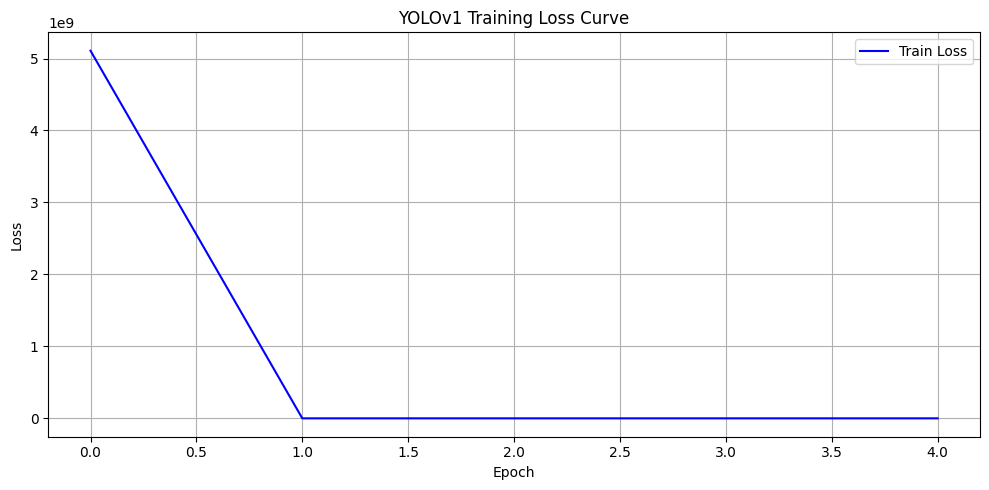

In [28]:
plot_loss_curve(loss_history)

In [29]:
def cellboxes_to_boxes(out, S=7, B=2, C=2):
    batch_size = out.shape[0]
    out = out.reshape(batch_size, S, S, C + 5 * B) # (N, S, S, C + B*5) 형태로 재구성

    # 각 Bounding Box 후보 (두 개)의 정보를 분리
    bboxes1 = out[..., :5]       # 첫 번째 Bbox 후보: [x, y, w, h, confidence]
    bboxes2 = out[..., 5:10]     # 두 번째 Bbox 후보: [x, y, w, h, confidence]

    # 두 Bbox 후보 중 더 높은 Confidence Score를 가진 것을 선택하기 위해 점수 비교
    scores = torch.cat([bboxes1[..., 4:5], bboxes2[..., 4:5]], dim=-1) 
    best_box = scores.argmax(-1).unsqueeze(-1) 

    best_boxes = bboxes1 * (1 - best_box) + bboxes2 * best_box 
    pred_boxes = best_boxes[..., :4]  

    # grid_x, grid_y는 각 셀의 좌상단 픽셀 위치를 나타내는 그리드 좌표 (0부터 S-1까지)
    grid_x = torch.arange(S, device=pred_boxes.device).repeat(S, 1).unsqueeze(0).unsqueeze(-1) 
    grid_y = torch.arange(S, device=pred_boxes.device).repeat(S, 1).T.unsqueeze(0).unsqueeze(-1) 

    # 실제 (x, y)는 이미지 전체에서 0~1 사이의 상대적인 중심 좌표
    x = (pred_boxes[..., 0].unsqueeze(-1) + grid_x) / S
    y = (pred_boxes[..., 1].unsqueeze(-1) + grid_y) / S
    
    # 예측된 (w, h)는 전체 이미지에 대한 0~1 사이의 상대적인 너비와 높이
    w = (pred_boxes[..., 2].unsqueeze(-1) ** 2) 
    h = (pred_boxes[..., 3].unsqueeze(-1) ** 2) # 제곱하여 원래 스케일 복원

    # 최종 변환된 바운딩 박스 좌표
    converted_boxes = torch.cat([x, y, w, h], dim=-1)

    # 클래스 예측 및 최종 신뢰도
    pred_cls = out[..., 10:].argmax(-1).unsqueeze(-1) # 가장 높은 확률을 가진 클래스 인덱스 (N, S, S, 1)
    best_conf = torch.max(scores, dim=-1)[0].unsqueeze(-1) # 선택된 Bbox의 Confidence Score (N, S, S, 1)

    # print(f"decoded box: {x}, {y}, {w}, {h}") # 디버깅 출력

    return torch.cat([converted_boxes, best_conf, pred_cls], dim=-1) # (N, S, S, 6)

In [30]:
# # IoU 계산 함수 (YOLOv1에서 사용하는 bounding box 형식: [x_center, y_center, width, height])
# def iou(boxes_preds, boxes_labels, eps=1e-6):
#     box1_x1 = boxes_preds[..., 0:1] - boxes_preds[..., 2:3] / 2
#     box1_y1 = boxes_preds[..., 1:2] - boxes_preds[..., 3:4] / 2
#     box1_x2 = boxes_preds[..., 0:1] + boxes_preds[..., 2:3] / 2
#     box1_y2 = boxes_preds[..., 1:2] + boxes_preds[..., 3:4] / 2
#     box2_x1 = boxes_labels[..., 0:1] - boxes_labels[..., 2:3] / 2
#     box2_y1 = boxes_labels[..., 1:2] - boxes_labels[..., 3:4] / 2
#     box2_x2 = boxes_labels[..., 0:1] + boxes_labels[..., 2:3] / 2
#     box2_y2 = boxes_labels[..., 1:2] + boxes_labels[..., 3:4] / 2

#     x1 = torch.max(box1_x1, box2_x1)
#     y1 = torch.max(box1_y1, box2_y1)
#     x2 = torch.min(box1_x2, box2_x2)
#     y2 = torch.min(box1_y2, box2_y2)

#     intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)
#     box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
#     box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))
#     union = box1_area + box2_area - intersection + 1e-6

#     return intersection / union


In [31]:
# 실제 NMS 함수
import torchvision.ops as ops

def nms(bboxes, iou_threshold=0.5, conf_threshold=0.5):
    filtered_bboxes_per_image = []

    for image_bboxes in bboxes:
        image_bboxes = [box for box in image_bboxes if box[4] > conf_threshold]

        if not image_bboxes:
            filtered_bboxes_per_image.append([])
            continue

        image_bboxes = sorted(image_bboxes, key=lambda x: x[4], reverse=True)

        final_boxes = []
        
        boxes_tensor = torch.tensor([box[0:4] for box in image_bboxes])
        scores_tensor = torch.tensor([box[4] for box in image_bboxes])
        class_ids_tensor = torch.tensor([box[5] for box in image_bboxes])

        x1 = boxes_tensor[:, 0] - boxes_tensor[:, 2] / 2
        y1 = boxes_tensor[:, 1] - boxes_tensor[:, 3] / 2
        x2 = boxes_tensor[:, 0] + boxes_tensor[:, 2] / 2
        y2 = boxes_tensor[:, 1] + boxes_tensor[:, 3] / 2
        boxes_xyxy = torch.stack([x1, y1, x2, y2], dim=-1)

        unique_classes = class_ids_tensor.unique()
        for cls_id in unique_classes:
            cls_mask = (class_ids_tensor == cls_id)
            cls_boxes = boxes_xyxy[cls_mask]
            cls_scores = scores_tensor[cls_mask]
            
            original_indices = torch.arange(len(image_bboxes))[cls_mask]

            keep_indices = ops.nms(cls_boxes, cls_scores, iou_threshold)
            
            for idx in keep_indices:
                final_boxes.append(image_bboxes[original_indices[idx]])
        
        final_boxes = sorted(final_boxes, key=lambda x: x[4], reverse=True)
        filtered_bboxes_per_image.append(final_boxes)

    return filtered_bboxes_per_image


In [32]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 폰트 경로: 직접 다운로드한 .ttf 파일의 경로
font_path = 'nanum/NanumGothic.ttf'  # Windows 예시
fontprop = fm.FontProperties(fname=font_path)

plt.rc('font', family=fontprop.get_name())
plt.rcParams['axes.unicode_minus'] = False

fm.fontManager.addfont(font_path)

In [33]:
def plot_image(image, boxes, class_labels):
    img = image.permute(1, 2, 0).cpu().numpy()
    h, w, _ = img.shape
    fig, ax = plt.subplots(1)
    ax.imshow(img)

    for box in boxes:
        class_pred = int(box[0])
        prob_score = box[1]
        x, y, bw, bh = box[2:]
        x, y, bw, bh = x * w, y * h, bw * w, bh * h

        top_left_x = x - bw / 2
        top_left_y = y - bh / 2

        rect = patches.Rectangle((top_left_x, top_left_y), bw, bh, linewidth=2, edgecolor="red", facecolor="none")
        ax.add_patch(rect)
        ax.text(top_left_x, top_left_y - 5, f"{class_labels[class_pred]} {prob_score:.2f}", color="white", fontsize=12, backgroundcolor="red")

    plt.axis("off")
    plt.show()

# eval

In [34]:
def plot_boxes(image, bboxes, class_names_map):
    if isinstance(image, torch.Tensor):
        image = image.permute(1, 2, 0).cpu().numpy()
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = image * std + mean
        image = np.clip(image, 0, 1) 
    
    fig, ax = plt.subplots(1)
    ax.imshow(image)

    H_img, W_img, _ = image.shape

    for box in bboxes:
        x_c, y_c, box_w, box_h, conf, model_class_idx = box

        x_min_px = (x_c - box_w / 2) * W_img
        y_min_px = (y_c - box_h / 2) * H_img
        width_px = box_w * W_img
        height_px = box_h * H_img

        rect = patches.Rectangle(
            (x_min_px, y_min_px),
            width_px,
            height_px,
            linewidth=2,
            edgecolor='r', 
            facecolor='none'
        )
        ax.add_patch(rect)

        model_class_idx_int = int(model_class_idx)
        if 0 <= model_class_idx_int < len(class_names_map):
            class_name = class_names_map[model_class_idx_int] # 리스트 인덱싱으로 접근
        else:
            class_name = f"Unknown Class_{model_class_idx_int}" # 유효하지 않은 인덱스 처리
        
        label_text = f"{class_name}: {conf:.2f}"
        
        plt.text(
            x_min_px, y_min_px - 5, 
            label_text,
            color='white',
            fontsize=8,
            bbox=dict(facecolor='red', alpha=0.5)
        )
    plt.axis('off')
    plt.show()

In [35]:
def evaluate(model, test_loader, class_labels, device, num_images=5):
    model.eval() 
    images_shown = 0

    with torch.no_grad(): 
        for batch_idx, (images, labels) in enumerate(tqdm(test_loader, desc="Evaluating")):
            images = images.to(device)
            

            outputs = model(images) 

            all_raw_bboxes_decoded = cellboxes_to_boxes(outputs, S=S, B=B, C=NUM_CLASSES)

            for i in range(images.shape[0]):
                if images_shown >= num_images:
                    break

                single_image_boxes_list = []
                for r in range(S):
                    for c in range(S):
                        box_info = all_raw_bboxes_decoded[i, r, c, :].tolist()
                        single_image_boxes_list.append(box_info)
                
                # NMS 함수는 batch 입력을 기대하므로, 단일 이미지 리스트를 한번 더 감싸서 전달
                nms_boxes_batch_result = nms([single_image_boxes_list], iou_threshold=0.4, conf_threshold=0.6)
                
                if nms_boxes_batch_result and nms_boxes_batch_result[0]:
                    plot_boxes(images[i].cpu(), nms_boxes_batch_result[0], class_labels) # <--- [0] 추가
                    print(f"Detected {len(nms_boxes_batch_result[0])} objects for image {batch_idx * test_loader.batch_size + i + 1}")
                else:
                    print(f"No objects detected for image {batch_idx * test_loader.batch_size + i + 1} with current thresholds.")

                images_shown += 1
            
            if images_shown >= num_images:
                break
    print("Evaluation finished.")

In [37]:
evaluate(model, test_loader, class_labels, device=device, num_images=5)

Evaluating:   0%|          | 0/843 [00:00<?, ?it/s]

MemoryError: bad allocation

<Figure size 640x480 with 1 Axes>

Evaluating:   0%|          | 1/843 [00:00<04:03,  3.46it/s]

Detected 37 objects for image 1


MemoryError: bad allocation

<Figure size 640x480 with 1 Axes>

Evaluating:   0%|          | 2/843 [00:00<02:41,  5.22it/s]

Detected 37 objects for image 2


MemoryError: bad allocation

<Figure size 640x480 with 1 Axes>

Evaluating:   0%|          | 3/843 [00:00<02:14,  6.23it/s]

Detected 37 objects for image 3


MemoryError: bad allocation

<Figure size 640x480 with 1 Axes>

Evaluating:   0%|          | 4/843 [00:00<02:02,  6.88it/s]

Detected 37 objects for image 4


MemoryError: bad allocation

<Figure size 640x480 with 1 Axes>

Evaluating:   0%|          | 4/843 [00:00<02:44,  5.11it/s]

Detected 37 objects for image 5
Evaluation finished.
